D:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0625
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0065
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0051
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0042
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0041
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0047
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0043
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0042
Epoch 9/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0038
Epoch 10/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0033
Epoch 11/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0030
Epoch 12/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0033
Epoch 13/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0034
Epoch 14/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0037
Epoch 15/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0028
Epoc

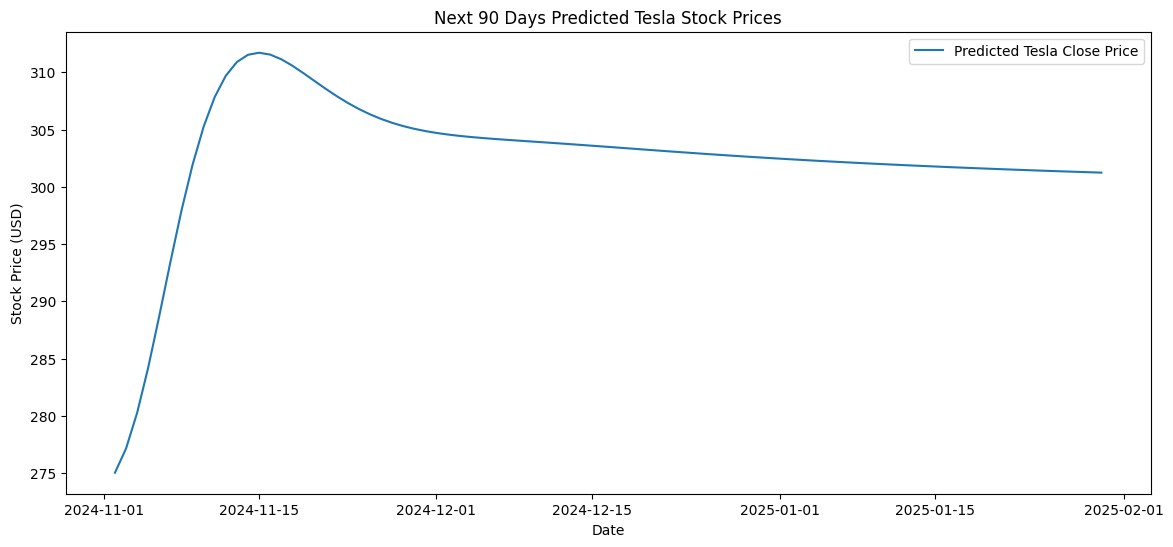

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

# Step 1: Load the data
tesla_data = pd.read_csv('Tesla_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('S&P500_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('IXIC_Close_2019_2024.csv', parse_dates=['Date'], index_col='Date')

# Merge datasets on 'Date'
merged_data = tesla_data.merge(sp500_data, left_index=True, right_index=True, suffixes=('', '_sp500'))
merged_data = merged_data.merge(ixic_data, left_index=True, right_index=True, suffixes=('', '_ixic'))

# Step 2: Preprocess the data
data = merged_data[['Close', 'Close_sp500', 'Close_ixic']]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the dataset for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i-time_step:i])
        y.append(dataset[i, 0])  # Predict the 'Close' price of Tesla
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

# Step 3: Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model on the entire dataset
model.fit(X, y, epochs=50, batch_size=32)

# Step 4: Dự đoán đoạn chưa có dữ liệu bằng cách dùng rolling window
last_60_days = scaled_data[-60:]  # Sử dụng 60 ngày gần nhất để khởi tạo đầu vào cho dự đoán
input_seq = last_60_days.reshape(1, last_60_days.shape[0], last_60_days.shape[1])

predictions = []
for _ in range(90):  # Dự đoán cho 90 ngày tiếp theo
    pred = model.predict(input_seq)
    predictions.append(pred[0, 0])
    
    # Thêm các giá trị dự đoán vào chuỗi đầu vào để tiếp tục dự đoán
    pred_with_features = np.array([[pred[0, 0], 0, 0]])  # Giả định các biến khác
    input_seq = np.append(input_seq[:, 1:, :], pred_with_features.reshape(1, 1, 3), axis=1)

# Inverse scale predictions to original scale
predictions = scaler.inverse_transform(np.concatenate([np.array(predictions).reshape(-1, 1), 
                                                       np.zeros((90, 2))], axis=1))[:, 0]

# Plot predictions
plt.figure(figsize=(14, 6))
plt.plot(pd.date_range(start='2024-11-02', periods=90), predictions, label='Predicted Tesla Close Price')
plt.title('Next 90 Days Predicted Tesla Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.show()


In [1]:
# Save the trained model to a file
model.save('tesla_stock_prediction_model.h5')
print("Model saved successfully.")


NameError: name 'model' is not defined